In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=2

In [3]:
print FOLD

2


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
from sklearn.linear_model import Ridge

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=['weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0', 'const_one', 'visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean', 'genre_name_visitors_mean', 'day_of_week_visitors_mean', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'visitor_ma2', 'visitor_ma4', 'visitor_ma7', 'visitor_ma14', 'visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 'visitor_sma2', 'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16', 'visitor_sma32', 'visitors_minus_ma28', 'visitors_divid_ma28', 'all_count_y1', 'geo1_count_y1', 'station_count_y1', 'geo2_count_y1', 'all_count_y2', 'geo1_count_y2', 'station_count_y2', 'geo2_count_y2', 'all_count_y3', 'geo1_count_y3', 'station_count_y3', 'geo2_count_y3', 'all_count_y4', 'geo1_count_y4', 'station_count_y4', 'geo2_count_y4', 'all_count_y5', 'geo1_count_y5', 'station_count_y5', 'geo2_count_y5', 'TMAX', 'TMIN', 'TAVG', 'PRCP', 'holiday', 's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio', 'f_t', 'bad_ratio', 'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean']
len(lag_cols)

72

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        gbm = Ridge()
        gbm.fit(trainX,trainy)

        models.append(gbm)
        validpred=gbm.predict(validX)
        scores.append(mean_squared_error(validy,validpred))
        print mean_squared_error(trainy,gbm.predict(trainX)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        X=np.concatenate([X,np.isnan(X)],1)
        X[np.isnan(X)]=0        
        pred=model.predict(X).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('3000_ridge_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(5803, 1, 18) (5803, 7, 72) (5803, 1) (5803, 1)
(5803, 522) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.68184407373e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26817656 0.2807883
[0.2807883]
-1 mean score 0.2807883
0.236287236214


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.940184 -0.011074  0.266273    7  2017-04-16
472     2.507290  2.568964 -0.061673  0.262357    1  2017-04-17
473     2.661330  2.642504  0.018826  0.277646    2  2017-04-18
474     2.754815  2.743393  0.011421  0.227862    3  2017-04-19
475     2.713762  2.715136 -0.001375  0.247014    4  2017-04-20
476     2.999000  2.980881  0.018118  0.166905    5  2017-04-21
477     3.075529  3.084516 -0.008986  0.205953    6  2017-04-22

0.236287251115


pred         y     error    error2  day        date
dayidx                                                         
471     2.940184  2.929110 -0.011074  0.266273    7  2017-04-16
472     2.568964  2.507290 -0.061673  0.262357    1  2017-04-17
473     2.642504  2.661330  0.018826  0.277646    2  2017-04-18
474     2.743393  2.754815  0.011421  0.227862    3  2017-04-19
475     2.715136  2.713762 -0.001375  0.247014    4  2017-04-20
476     2.980881  2.999000  0.018118  0.166905    5  2017-04-21
477     3.084516  3.075529 -0.008986  0.205953    6  2017-04-22

(829, 1044)


2
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(6632, 1, 18) (6632, 7, 72) (6632, 1) (6632, 1)
(6632, 522) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.97767477079e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26380706 0.27528515
[0.27528515]
-1 mean score 0.27528515
0.238333120942


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915166  0.013944  0.268287    7  2017-04-16
472     2.507290  2.572465 -0.065175  0.263460    1  2017-04-17
473     2.661330  2.668063 -0.006734  0.280573    2  2017-04-18
474     2.754815  2.756593 -0.001778  0.231428    3  2017-04-19
475     2.713762  2.718390 -0.004629  0.247838    4  2017-04-20
476     2.999000  3.001888 -0.002888  0.172321    5  2017-04-21
477     3.075529  3.054582  0.020947  0.204423    6  2017-04-22

0.238333120942


pred         y     error    error2  day        date
dayidx                                                         
471     2.915166  2.929110  0.013944  0.268287    7  2017-04-16
472     2.572465  2.507290 -0.065175  0.263460    1  2017-04-17
473     2.668063  2.661330 -0.006734  0.280573    2  2017-04-18
474     2.756593  2.754815 -0.001778  0.231428    3  2017-04-19
475     2.718390  2.713762 -0.004629  0.247838    4  2017-04-20
476     3.001888  2.999000 -0.002888  0.172321    5  2017-04-21
477     3.054582  3.075529  0.020947  0.204423    6  2017-04-22

(829, 1044)


3
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(7461, 1, 18) (7461, 7, 72) (7461, 1) (7461, 1)
(7461, 522) (7461,) (7461,)
0.2677416 0.28010434
[0.28010434]
-1 mean score 0.28010434
0.239788100123


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914432  0.014678  0.268009    7  2017-04-16
472     2.507290  2.586485 -0.079195  0.262537    1  2017-04-17
473     2.661330  2.653700  0.007630  0.282916    2  2017-04-18
474     2.754815  2.771417 -0.016602  0.233436    3  2017-04-19
475     2.713762  2.738626 -0.024864  0.254146    4  2017-04-20
476     2.999000  2.997258  0.001741  0.174713    5  2017-04-21
477     3.075529  3.071877  0.003652  0.202760    6  2017-04-22

0.239788129926


pred         y     error    error2  day        date
dayidx                                                         
471     2.914432  2.929110  0.014678  0.268009    7  2017-04-16
472     2.586485  2.507290 -0.079195  0.262537    1  2017-04-17
473     2.653700  2.661330  0.007630  0.282916    2  2017-04-18
474     2.771417  2.754815 -0.016602  0.233436    3  2017-04-19
475     2.738626  2.713762 -0.024864  0.254146    4  2017-04-20
476     2.997258  2.999000  0.001741  0.174713    5  2017-04-21
477     3.071877  3.075529  0.003653  0.202760    6  2017-04-22

(829, 1044)


4
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(8290, 1, 18) (8290, 7, 72) (8290, 1) (8290, 1)
(8290, 522) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.58871570014e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26848558 0.28021565
[0.28021565]
-1 mean score 0.28021565
0.242064341903


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902120  0.026990  0.271726    7  2017-04-16
472     2.507290  2.588289 -0.080998  0.263714    1  2017-04-17
473     2.661330  2.625442  0.035888  0.288037    2  2017-04-18
474     2.754815  2.762368 -0.007553  0.232670    3  2017-04-19
475     2.713762  2.738838 -0.025076  0.258465    4  2017-04-20
476     2.999000  2.968741  0.030258  0.177793    5  2017-04-21
477     3.075529  3.073967  0.001562  0.202045    6  2017-04-22

0.242064327002


pred         y     error    error2  day        date
dayidx                                                         
471     2.902120  2.929110  0.026990  0.271726    7  2017-04-16
472     2.588289  2.507290 -0.080998  0.263714    1  2017-04-17
473     2.625442  2.661330  0.035888  0.288037    2  2017-04-18
474     2.762368  2.754815 -0.007553  0.232670    3  2017-04-19
475     2.738838  2.713762 -0.025076  0.258465    4  2017-04-20
476     2.968741  2.999000  0.030258  0.177793    5  2017-04-21
477     3.073967  3.075529  0.001562  0.202045    6  2017-04-22

(829, 1044)


5
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(9119, 1, 18) (9119, 7, 72) (9119, 1) (9119, 1)
(9119, 522) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.74071729253e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26875332 0.27890772
[0.27890772]
-1 mean score 0.27890772
0.242981776595


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909474  0.019636  0.271363    7  2017-04-16
472     2.507290  2.582041 -0.074751  0.264745    1  2017-04-17
473     2.661330  2.626424  0.034906  0.288097    2  2017-04-18
474     2.754815  2.738386  0.016429  0.230995    3  2017-04-19
475     2.713762  2.719866 -0.006104  0.260353    4  2017-04-20
476     2.999000  2.965938  0.033062  0.179441    5  2017-04-21
477     3.075529  3.048208  0.027322  0.205879    6  2017-04-22

0.242981776595


pred         y     error    error2  day        date
dayidx                                                         
471     2.909474  2.929110  0.019636  0.271363    7  2017-04-16
472     2.582041  2.507290 -0.074751  0.264745    1  2017-04-17
473     2.626424  2.661330  0.034906  0.288097    2  2017-04-18
474     2.738386  2.754815  0.016429  0.230995    3  2017-04-19
475     2.719866  2.713762 -0.006104  0.260353    4  2017-04-20
476     2.965938  2.999000  0.033062  0.179441    5  2017-04-21
477     3.048208  3.075529  0.027322  0.205879    6  2017-04-22

(829, 1044)


6
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 15.133374
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(9948, 1, 18) (9948, 7, 72) (9948, 1) (9948, 1)
(9948, 522) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.3561157993e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27042452 0.2817524
[0.2817524]
-1 mean score 0.2817524
0.243959546089


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919657  0.009453  0.272641    7  2017-04-16
472     2.507290  2.587837 -0.080547  0.267429    1  2017-04-17
473     2.661330  2.627761  0.033569  0.290658    2  2017-04-18
474     2.754815  2.740744  0.014071  0.230607    3  2017-04-19
475     2.713762  2.720285 -0.006524  0.258556    4  2017-04-20
476     2.999000  2.956636  0.042364  0.181124    5  2017-04-21
477     3.075529  3.079626 -0.004097  0.206702    6  2017-04-22

0.243959546089


pred         y     error    error2  day        date
dayidx                                                         
471     2.919657  2.929110  0.009453  0.272641    7  2017-04-16
472     2.587837  2.507290 -0.080547  0.267429    1  2017-04-17
473     2.627761  2.661330  0.033569  0.290658    2  2017-04-18
474     2.740744  2.754815  0.014071  0.230607    3  2017-04-19
475     2.720285  2.713762 -0.006524  0.258556    4  2017-04-20
476     2.956636  2.999000  0.042364  0.181124    5  2017-04-21
477     3.079626  3.075529 -0.004097  0.206702    6  2017-04-22

(829, 1044)


7
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 16.310143
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(10777, 1, 18) (10777, 7, 72) (10777, 1) (10777, 1)
(10777, 522) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.30806744445e-11 / 5.96046447754e-08
  RuntimeWarning)


0.26702964 0.28017777
[0.28017777]
-1 mean score 0.28017777
0.245033428073


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905920  0.023190  0.272902    7  2017-04-16
472     2.507290  2.595812 -0.088521  0.272978    1  2017-04-17
473     2.661330  2.645504  0.015826  0.294102    2  2017-04-18
474     2.754815  2.728728  0.026087  0.235910    3  2017-04-19
475     2.713762  2.728449 -0.014688  0.257664    4  2017-04-20
476     2.999000  2.966677  0.032322  0.178859    5  2017-04-21
477     3.075529  3.088090 -0.012561  0.202820    6  2017-04-22

0.245033428073


pred         y     error    error2  day        date
dayidx                                                         
471     2.905920  2.929110  0.023190  0.272902    7  2017-04-16
472     2.595812  2.507290 -0.088521  0.272978    1  2017-04-17
473     2.645504  2.661330  0.015826  0.294102    2  2017-04-18
474     2.728728  2.754815  0.026087  0.235910    3  2017-04-19
475     2.728449  2.713762 -0.014688  0.257664    4  2017-04-20
476     2.966677  2.999000  0.032322  0.178859    5  2017-04-21
477     3.088090  3.075529 -0.012561  0.202820    6  2017-04-22

(829, 1044)


8
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 17.574337
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(11606, 1, 18) (11606, 7, 72) (11606, 1) (11606, 1)
(11606, 522) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.1027502416e-12 / 5.96046447754e-08
  RuntimeWarning)


0.26584852 0.28008252
[0.28008252]
-1 mean score 0.28008252
0.251533657312


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.934148 -0.005038  0.279944    7  2017-04-16
472     2.507290  2.604568 -0.097278  0.274876    1  2017-04-17
473     2.661330  2.667071 -0.005741  0.299111    2  2017-04-18
474     2.754815  2.752975  0.001840  0.250680    3  2017-04-19
475     2.713762  2.726832 -0.013070  0.265023    4  2017-04-20
476     2.999000  2.977395  0.021604  0.188364    5  2017-04-21
477     3.075529  3.090868 -0.015339  0.202738    6  2017-04-22

0.251533657312


pred         y     error    error2  day        date
dayidx                                                         
471     2.934148  2.929110 -0.005038  0.279944    7  2017-04-16
472     2.604568  2.507290 -0.097278  0.274876    1  2017-04-17
473     2.667070  2.661330 -0.005741  0.299111    2  2017-04-18
474     2.752975  2.754815  0.001840  0.250680    3  2017-04-19
475     2.726832  2.713762 -0.013070  0.265023    4  2017-04-20
476     2.977395  2.999000  0.021604  0.188364    5  2017-04-21
477     3.090868  3.075529 -0.015339  0.202738    6  2017-04-22

(829, 1044)


9
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 18.806503
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(12435, 1, 18) (12435, 7, 72) (12435, 1) (12435, 1)
(12435, 522) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.61083463876e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27388263 0.28886947
[0.28886947]
-1 mean score 0.28886947
0.252507120371


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.934041 -0.004931  0.279033    7  2017-04-16
472     2.507290  2.629821 -0.122531  0.281263    1  2017-04-17
473     2.661330  2.687602 -0.026272  0.302840    2  2017-04-18
474     2.754815  2.761812 -0.006998  0.248807    3  2017-04-19
475     2.713762  2.742647 -0.028886  0.266720    4  2017-04-20
476     2.999000  2.968799  0.030201  0.187905    5  2017-04-21
477     3.075529  3.091229 -0.015700  0.200981    6  2017-04-22

0.252507120371


pred         y     error    error2  day        date
dayidx                                                         
471     2.934041  2.929110 -0.004931  0.279033    7  2017-04-16
472     2.629821  2.507290 -0.122531  0.281263    1  2017-04-17
473     2.687602  2.661330 -0.026272  0.302840    2  2017-04-18
474     2.761812  2.754815 -0.006998  0.248807    3  2017-04-19
475     2.742647  2.713762 -0.028886  0.266720    4  2017-04-20
476     2.968799  2.999000  0.030201  0.187905    5  2017-04-21
477     3.091229  3.075529 -0.015700  0.200981    6  2017-04-22

(829, 1044)


10
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 19.926521
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(13264, 1, 18) (13264, 7, 72) (13264, 1) (13264, 1)
(13264, 522) (13264,) (13264,)
0.27795798 0.29060188
[0.29060188]
-1 mean score 0.29060188
0.252805620432


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.95827667918e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.935829 -0.006719  0.279442    7  2017-04-16
472     2.507290  2.631049 -0.123759  0.279806    1  2017-04-17
473     2.661330  2.691262 -0.029932  0.307538    2  2017-04-18
474     2.754815  2.748868  0.005947  0.250221    3  2017-04-19
475     2.713762  2.746476 -0.032714  0.267533    4  2017-04-20
476     2.999000  2.992609  0.006391  0.185668    5  2017-04-21
477     3.075529  3.077703 -0.002173  0.199431    6  2017-04-22

0.252805620432


pred         y     error    error2  day        date
dayidx                                                         
471     2.935829  2.929110 -0.006719  0.279442    7  2017-04-16
472     2.631049  2.507290 -0.123759  0.279806    1  2017-04-17
473     2.691262  2.661330 -0.029932  0.307538    2  2017-04-18
474     2.748868  2.754815  0.005947  0.250221    3  2017-04-19
475     2.746476  2.713762 -0.032714  0.267533    4  2017-04-20
476     2.992609  2.999000  0.006391  0.185668    5  2017-04-21
477     3.077703  3.075529 -0.002173  0.199431    6  2017-04-22

(829, 1044)


11
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 21.05768
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(14093, 1, 18) (14093, 7, 72) (14093, 1) (14093, 1)
(14093, 522) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.61314761233e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2778326 0.29292256
[0.29292256]
-1 mean score 0.29292256
0.25322458148


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.940196 -0.011086  0.279234    7  2017-04-16
472     2.507290  2.644791 -0.137501  0.284742    1  2017-04-17
473     2.661330  2.702262 -0.040932  0.307041    2  2017-04-18
474     2.754815  2.729556  0.025259  0.249904    3  2017-04-19
475     2.713762  2.733797 -0.020035  0.267953    4  2017-04-20
476     2.999000  2.992566  0.006433  0.183670    5  2017-04-21
477     3.075529  3.080206 -0.004677  0.200028    6  2017-04-22

0.25322458148


pred         y     error    error2  day        date
dayidx                                                         
471     2.940196  2.929110 -0.011086  0.279234    7  2017-04-16
472     2.644791  2.507290 -0.137501  0.284742    1  2017-04-17
473     2.702262  2.661330 -0.040932  0.307041    2  2017-04-18
474     2.729556  2.754815  0.025259  0.249904    3  2017-04-19
475     2.733797  2.713762 -0.020035  0.267953    4  2017-04-20
476     2.992566  2.999000  0.006433  0.183670    5  2017-04-21
477     3.080206  3.075529 -0.004677  0.200028    6  2017-04-22

(829, 1044)


12
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 22.115147
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(14922, 1, 18) (14922, 7, 72) (14922, 1) (14922, 1)
(14922, 522) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.46381922881e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27876928 0.2907482
[0.2907482]
-1 mean score 0.2907482
0.25364407897


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.942974 -0.013864  0.279088    7  2017-04-16
472     2.507290  2.646461 -0.139171  0.284461    1  2017-04-17
473     2.661330  2.705285 -0.043955  0.302396    2  2017-04-18
474     2.754815  2.733527  0.021287  0.251398    3  2017-04-19
475     2.713762  2.728397 -0.014635  0.270585    4  2017-04-20
476     2.999000  2.983786  0.015214  0.186276    5  2017-04-21
477     3.075529  3.085225 -0.009696  0.201304    6  2017-04-22

0.25364407897


pred         y     error    error2  day        date
dayidx                                                         
471     2.942974  2.929110 -0.013864  0.279088    7  2017-04-16
472     2.646461  2.507290 -0.139171  0.284461    1  2017-04-17
473     2.705285  2.661330 -0.043955  0.302396    2  2017-04-18
474     2.733527  2.754815  0.021287  0.251398    3  2017-04-19
475     2.728397  2.713762 -0.014635  0.270585    4  2017-04-20
476     2.983786  2.999000  0.015214  0.186276    5  2017-04-21
477     3.085225  3.075529 -0.009696  0.201304    6  2017-04-22

(829, 1044)


13
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 23.15517
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(15751, 1, 18) (15751, 7, 72) (15751, 1) (15751, 1)
(15751, 522) (15751,) (15751,)
0.2790388 0.29355127
[0.29355127]
-1 mean score 0.29355127
0.254934489727


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.50408328426e-12 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.939409 -0.010299  0.283673    7  2017-04-16
472     2.507290  2.665986 -0.158696  0.290875    1  2017-04-17
473     2.661330  2.693256 -0.031926  0.300835    2  2017-04-18
474     2.754815  2.718416  0.036399  0.251734    3  2017-04-19
475     2.713762  2.720091 -0.006329  0.269293    4  2017-04-20
476     2.999000  2.999901 -0.000902  0.186084    5  2017-04-21
477     3.075529  3.068941  0.006589  0.202047    6  2017-04-22

0.254934519529


pred         y     error    error2  day        date
dayidx                                                         
471     2.939409  2.929110 -0.010299  0.283673    7  2017-04-16
472     2.665986  2.507290 -0.158696  0.290875    1  2017-04-17
473     2.693256  2.661330 -0.031926  0.300835    2  2017-04-18
474     2.718416  2.754815  0.036399  0.251734    3  2017-04-19
475     2.720091  2.713762 -0.006329  0.269293    4  2017-04-20
476     2.999901  2.999000 -0.000902  0.186084    5  2017-04-21
477     3.068941  3.075529  0.006589  0.202047    6  2017-04-22

(829, 1044)


14
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 24.22639
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(16580, 1, 18) (16580, 7, 72) (16580, 1) (16580, 1)
(16580, 522) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.52528118344e-12 / 5.96046447754e-08
  RuntimeWarning)


0.27536613 0.29128757
[0.29128757]
-1 mean score 0.29128757
0.256465286016


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.942157 -0.013047  0.284705    7  2017-04-16
472     2.507290  2.660904 -0.153614  0.294182    1  2017-04-17
473     2.661330  2.688274 -0.026944  0.303731    2  2017-04-18
474     2.754815  2.702089  0.052725  0.258116    3  2017-04-19
475     2.713762  2.714698 -0.000936  0.267524    4  2017-04-20
476     2.999000  3.008549 -0.009549  0.182759    5  2017-04-21
477     3.075529  3.062732  0.012797  0.204240    6  2017-04-22

0.256465256214


pred         y     error    error2  day        date
dayidx                                                         
471     2.942157  2.929110 -0.013047  0.284705    7  2017-04-16
472     2.660904  2.507290 -0.153614  0.294182    1  2017-04-17
473     2.688273  2.661330 -0.026944  0.303731    2  2017-04-18
474     2.702089  2.754815  0.052725  0.258116    3  2017-04-19
475     2.714698  2.713762 -0.000936  0.267524    4  2017-04-20
476     3.008549  2.999000 -0.009549  0.182759    5  2017-04-21
477     3.062732  3.075529  0.012797  0.204240    6  2017-04-22

(829, 1044)


15
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 25.357664
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(17409, 1, 18) (17409, 7, 72) (17409, 1) (17409, 1)
(17409, 522) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.50929440557e-12 / 5.96046447754e-08
  RuntimeWarning)


0.27384624 0.28828204
[0.28828204]
-1 mean score 0.28828204
0.263332098722


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.993415 -0.064305  0.307243    7  2017-04-16
472     2.507290  2.663216 -0.155925  0.301365    1  2017-04-17
473     2.661330  2.702985 -0.041655  0.311862    2  2017-04-18
474     2.754815  2.712292  0.042523  0.255514    3  2017-04-19
475     2.713762  2.709599  0.004162  0.277203    4  2017-04-20
476     2.999000  2.999345 -0.000345  0.184567    5  2017-04-21
477     3.075529  3.053420  0.022109  0.205571    6  2017-04-22

0.263332098722


pred         y     error    error2  day        date
dayidx                                                         
471     2.993415  2.929110 -0.064305  0.307243    7  2017-04-16
472     2.663216  2.507290 -0.155925  0.301365    1  2017-04-17
473     2.702985  2.661330 -0.041655  0.311862    2  2017-04-18
474     2.712292  2.754815  0.042523  0.255514    3  2017-04-19
475     2.709599  2.713762  0.004162  0.277203    4  2017-04-20
476     2.999345  2.999000 -0.000345  0.184567    5  2017-04-21
477     3.053420  3.075529  0.022109  0.205571    6  2017-04-22

(829, 1044)


16
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 26.465925
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(18238, 1, 18) (18238, 7, 72) (18238, 1) (18238, 1)
(18238, 522) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.96516020743e-13 / 5.96046447754e-08
  RuntimeWarning)


0.28139472 0.2983056
[0.2983056]
-1 mean score 0.2983056
0.265761882067


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.979081 -0.049971  0.301911    7  2017-04-16
472     2.507290  2.678609 -0.171318  0.310758    1  2017-04-17
473     2.661330  2.710466 -0.049136  0.314824    2  2017-04-18
474     2.754815  2.713084  0.041731  0.258669    3  2017-04-19
475     2.713762  2.718616 -0.004854  0.277602    4  2017-04-20
476     2.999000  2.994693  0.004307  0.188691    5  2017-04-21
477     3.075529  3.063725  0.011804  0.207878    6  2017-04-22

0.265761882067


pred         y     error    error2  day        date
dayidx                                                         
471     2.979081  2.929110 -0.049972  0.301911    7  2017-04-16
472     2.678609  2.507290 -0.171318  0.310758    1  2017-04-17
473     2.710466  2.661330 -0.049136  0.314824    2  2017-04-18
474     2.713084  2.754815  0.041731  0.258669    3  2017-04-19
475     2.718616  2.713762 -0.004854  0.277602    4  2017-04-20
476     2.994693  2.999000  0.004307  0.188691    5  2017-04-21
477     3.063725  3.075529  0.011804  0.207878    6  2017-04-22

(829, 1044)


17
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 27.605818
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(19067, 1, 18) (19067, 7, 72) (19067, 1) (19067, 1)
(19067, 522) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.40312734989e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28429067 0.30103603
[0.30103603]
-1 mean score 0.30103603
0.263846665621


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.968776 -0.039667  0.298649    7  2017-04-16
472     2.507290  2.639231 -0.131941  0.300465    1  2017-04-17
473     2.661330  2.690465 -0.029135  0.312450    2  2017-04-18
474     2.754815  2.720150  0.034665  0.259643    3  2017-04-19
475     2.713762  2.709271  0.004490  0.279091    4  2017-04-20
476     2.999000  3.008209 -0.009210  0.189850    5  2017-04-21
477     3.075529  3.053618  0.021911  0.206778    6  2017-04-22

0.263846665621


pred         y     error    error2  day        date
dayidx                                                         
471     2.968777  2.929110 -0.039667  0.298649    7  2017-04-16
472     2.639231  2.507290 -0.131941  0.300465    1  2017-04-17
473     2.690465  2.661330 -0.029135  0.312450    2  2017-04-18
474     2.720150  2.754815  0.034665  0.259643    3  2017-04-19
475     2.709271  2.713762  0.004490  0.279091    4  2017-04-20
476     3.008209  2.999000 -0.009210  0.189850    5  2017-04-21
477     3.053618  3.075529  0.021911  0.206778    6  2017-04-22

(829, 1044)


18
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 28.75126
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(19896, 1, 18) (19896, 7, 72) (19896, 1) (19896, 1)
(19896, 522) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.74976724618e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2846109 0.30118906
[0.30118906]
-1 mean score 0.30118906
0.264251887798


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.969584 -0.040474  0.303993    7  2017-04-16
472     2.507290  2.624192 -0.116901  0.296452    1  2017-04-17
473     2.661330  2.681279 -0.019949  0.314145    2  2017-04-18
474     2.754815  2.726908  0.027907  0.258667    3  2017-04-19
475     2.713762  2.700932  0.012830  0.277463    4  2017-04-20
476     2.999000  3.003143 -0.004143  0.192066    5  2017-04-21
477     3.075529  3.046223  0.029306  0.206976    6  2017-04-22

0.264251917601


pred         y     error    error2  day        date
dayidx                                                         
471     2.969584  2.929110 -0.040474  0.303993    7  2017-04-16
472     2.624192  2.507290 -0.116901  0.296452    1  2017-04-17
473     2.681279  2.661330 -0.019949  0.314145    2  2017-04-18
474     2.726908  2.754815  0.027907  0.258667    3  2017-04-19
475     2.700932  2.713762  0.012830  0.277463    4  2017-04-20
476     3.003143  2.999000 -0.004143  0.192066    5  2017-04-21
477     3.046223  3.075529  0.029306  0.206976    6  2017-04-22

(829, 1044)


19
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 29.798643
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(20725, 1, 18) (20725, 7, 72) (20725, 1) (20725, 1)
(20725, 522) (20725,) (20725,)
0.2835844 0.29903308
[0.29903308]
-1 mean score 0.29903308
0.264789670706


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.94658221434e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.938835 -0.009726  0.304734    7  2017-04-16
472     2.507290  2.627799 -0.120509  0.294767    1  2017-04-17
473     2.661330  2.660388  0.000941  0.309369    2  2017-04-18
474     2.754815  2.699116  0.055699  0.261440    3  2017-04-19
475     2.713762  2.724939 -0.011178  0.282244    4  2017-04-20
476     2.999000  2.990314  0.008686  0.192895    5  2017-04-21
477     3.075529  3.055274  0.020255  0.208079    6  2017-04-22

0.264789670706


pred         y     error    error2  day        date
dayidx                                                         
471     2.938835  2.929110 -0.009726  0.304734    7  2017-04-16
472     2.627799  2.507290 -0.120509  0.294767    1  2017-04-17
473     2.660388  2.661330  0.000941  0.309369    2  2017-04-18
474     2.699116  2.754815  0.055699  0.261440    3  2017-04-19
475     2.724939  2.713762 -0.011178  0.282244    4  2017-04-20
476     2.990314  2.999000  0.008686  0.192895    5  2017-04-21
477     3.055274  3.075529  0.020255  0.208079    6  2017-04-22

(829, 1044)


20
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 30.796307
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(21554, 1, 18) (21554, 7, 72) (21554, 1) (21554, 1)
(21554, 522) (21554,) (21554,)
0.2852683 0.30210102
[0.30210102]
-1 mean score 0.30210102
0.265119582415


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.43136907777e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.981594 -0.052484  0.310993    7  2017-04-16
472     2.507290  2.593952 -0.086662  0.287680    1  2017-04-17
473     2.661330  2.679895 -0.018566  0.309944    2  2017-04-18
474     2.754815  2.700632  0.054183  0.261526    3  2017-04-19
475     2.713762  2.698945  0.014816  0.284712    4  2017-04-20
476     2.999000  2.984781  0.014218  0.190886    5  2017-04-21
477     3.075529  3.062359  0.013170  0.210096    6  2017-04-22

0.265119612217


pred         y     error    error2  day        date
dayidx                                                         
471     2.981594  2.929110 -0.052484  0.310993    7  2017-04-16
472     2.593952  2.507290 -0.086662  0.287680    1  2017-04-17
473     2.679895  2.661330 -0.018566  0.309945    2  2017-04-18
474     2.700632  2.754815  0.054183  0.261526    3  2017-04-19
475     2.698945  2.713762  0.014816  0.284712    4  2017-04-20
476     2.984781  2.999000  0.014218  0.190886    5  2017-04-21
477     3.062359  3.075529  0.013170  0.210096    6  2017-04-22

(829, 1044)


21
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 31.792852
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(22383, 1, 18) (22383, 7, 72) (22383, 1) (22383, 1)
(22383, 522) (22383,) (22383,)
0.2813096 0.29655972
[0.29655972]
-1 mean score 0.29655972
0.266440272331


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.92058990239e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901967  0.027143  0.305587    7  2017-04-16
472     2.507290  2.592708 -0.085418  0.285933    1  2017-04-17
473     2.661330  2.657225  0.004105  0.310269    2  2017-04-18
474     2.754815  2.701623  0.053192  0.263550    3  2017-04-19
475     2.713762  2.674290  0.039472  0.286131    4  2017-04-20
476     2.999000  2.931960  0.067040  0.199591    5  2017-04-21
477     3.075529  3.079375 -0.003846  0.214021    6  2017-04-22

0.266440272331


pred         y     error    error2  day        date
dayidx                                                         
471     2.901967  2.929110  0.027143  0.305587    7  2017-04-16
472     2.592708  2.507290 -0.085418  0.285933    1  2017-04-17
473     2.657225  2.661330  0.004105  0.310269    2  2017-04-18
474     2.701623  2.754815  0.053192  0.263550    3  2017-04-19
475     2.674290  2.713762  0.039472  0.286131    4  2017-04-20
476     2.931960  2.999000  0.067040  0.199591    5  2017-04-21
477     3.079375  3.075529 -0.003846  0.214021    6  2017-04-22

(829, 1044)


22
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 32.870983
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(23212, 1, 18) (23212, 7, 72) (23212, 1) (23212, 1)
(23212, 522) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.7909762135e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2782568 0.29354948
[0.29354948]
-1 mean score 0.29354948
0.267075866461


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907859  0.021251  0.300113    7  2017-04-16
472     2.507290  2.528331 -0.021041  0.290306    1  2017-04-17
473     2.661330  2.656076  0.005254  0.309145    2  2017-04-18
474     2.754815  2.685891  0.068923  0.265749    3  2017-04-19
475     2.713762  2.697951  0.015810  0.290266    4  2017-04-20
476     2.999000  2.921782  0.077218  0.202158    5  2017-04-21
477     3.075529  3.054022  0.021507  0.211794    6  2017-04-22

0.267075866461


pred         y     error    error2  day        date
dayidx                                                         
471     2.907859  2.929110  0.021251  0.300113    7  2017-04-16
472     2.528331  2.507290 -0.021041  0.290306    1  2017-04-17
473     2.656076  2.661330  0.005254  0.309145    2  2017-04-18
474     2.685892  2.754815  0.068923  0.265749    3  2017-04-19
475     2.697951  2.713762  0.015810  0.290266    4  2017-04-20
476     2.921782  2.999000  0.077218  0.202158    5  2017-04-21
477     3.054022  3.075529  0.021507  0.211794    6  2017-04-22

(829, 1044)


23
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 33.974537
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(24041, 1, 18) (24041, 7, 72) (24041, 1) (24041, 1)
(24041, 522) (24041,) (24041,)
0.2851971 0.30266973
[0.30266973]
-1 mean score 0.30266973
0.26603743434


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.42848674398e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915530  0.013580  0.294248    7  2017-04-16
472     2.507290  2.479488  0.027802  0.291426    1  2017-04-17
473     2.661330  2.652741  0.008589  0.311784    2  2017-04-18
474     2.754815  2.692360  0.062454  0.265388    3  2017-04-19
475     2.713762  2.683950  0.029812  0.289850    4  2017-04-20
476     2.999000  2.947538  0.051461  0.199277    5  2017-04-21
477     3.075529  3.056608  0.018921  0.210290    6  2017-04-22

0.26603743434


pred         y     error    error2  day        date
dayidx                                                         
471     2.915530  2.929110  0.013580  0.294248    7  2017-04-16
472     2.479488  2.507290  0.027802  0.291426    1  2017-04-17
473     2.652741  2.661330  0.008589  0.311784    2  2017-04-18
474     2.692360  2.754815  0.062454  0.265388    3  2017-04-19
475     2.683950  2.713762  0.029812  0.289850    4  2017-04-20
476     2.947538  2.999000  0.051461  0.199277    5  2017-04-21
477     3.056608  3.075529  0.018921  0.210290    6  2017-04-22

(829, 1044)


24
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 35.208443
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(24870, 1, 18) (24870, 7, 72) (24870, 1) (24870, 1)
(24870, 522) (24870,) (24870,)
0.28846902 0.30370253
[0.30370253]
-1 mean score 0.30370253
0.266185671091


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.66244708172e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905281  0.023829  0.290262    7  2017-04-16
472     2.507290  2.498508  0.008783  0.287992    1  2017-04-17
473     2.661330  2.635840  0.025489  0.310871    2  2017-04-18
474     2.754815  2.668712  0.086103  0.270422    3  2017-04-19
475     2.713762  2.701624  0.012138  0.291773    4  2017-04-20
476     2.999000  2.933402  0.065598  0.201265    5  2017-04-21
477     3.075529  3.067637  0.007892  0.210713    6  2017-04-22

0.266185671091


pred         y     error    error2  day        date
dayidx                                                         
471     2.905281  2.929110  0.023829  0.290262    7  2017-04-16
472     2.498508  2.507290  0.008783  0.287992    1  2017-04-17
473     2.635840  2.661330  0.025489  0.310871    2  2017-04-18
474     2.668712  2.754815  0.086103  0.270422    3  2017-04-19
475     2.701624  2.713762  0.012138  0.291773    4  2017-04-20
476     2.933402  2.999000  0.065598  0.201265    5  2017-04-21
477     3.067637  3.075529  0.007892  0.210713    6  2017-04-22

(829, 1044)


25
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 36.335064
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(25699, 1, 18) (25699, 7, 72) (25699, 1) (25699, 1)
(25699, 522) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.96520967502e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28875634 0.30390987
[0.30390987]
-1 mean score 0.30390987
0.267207711935


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886458  0.042652  0.293209    7  2017-04-16
472     2.507290  2.497220  0.010070  0.289622    1  2017-04-17
473     2.661330  2.641849  0.019481  0.310790    2  2017-04-18
474     2.754815  2.668279  0.086535  0.272119    3  2017-04-19
475     2.713762  2.626764  0.086997  0.295668    4  2017-04-20
476     2.999000  2.963942  0.035058  0.196540    5  2017-04-21
477     3.075529  3.064844  0.010685  0.212507    6  2017-04-22

0.267207711935


pred         y     error    error2  day        date
dayidx                                                         
471     2.886458  2.929110  0.042652  0.293209    7  2017-04-16
472     2.497220  2.507290  0.010070  0.289622    1  2017-04-17
473     2.641849  2.661330  0.019481  0.310790    2  2017-04-18
474     2.668279  2.754815  0.086535  0.272119    3  2017-04-19
475     2.626764  2.713762  0.086997  0.295668    4  2017-04-20
476     2.963942  2.999000  0.035058  0.196540    5  2017-04-21
477     3.064844  3.075529  0.010685  0.212507    6  2017-04-22

(829, 1044)


26
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 37.374123
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(26528, 1, 18) (26528, 7, 72) (26528, 1) (26528, 1)
(26528, 522) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.89153292923e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2880536 0.30438676
[0.30438676]
-1 mean score 0.30438676
0.269195467234


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888826  0.040284  0.294416    7  2017-04-16
472     2.507290  2.480576  0.026715  0.289540    1  2017-04-17
473     2.661330  2.641997  0.019333  0.312038    2  2017-04-18
474     2.754815  2.677742  0.077073  0.269274    3  2017-04-19
475     2.713762  2.595874  0.117888  0.305363    4  2017-04-20
476     2.999000  2.946386  0.052613  0.199420    5  2017-04-21
477     3.075529  3.060019  0.015510  0.214316    6  2017-04-22

0.269195467234


pred         y     error    error2  day        date
dayidx                                                         
471     2.888826  2.929110  0.040284  0.294416    7  2017-04-16
472     2.480576  2.507290  0.026715  0.289540    1  2017-04-17
473     2.641997  2.661330  0.019333  0.312038    2  2017-04-18
474     2.677742  2.754815  0.077073  0.269274    3  2017-04-19
475     2.595874  2.713762  0.117888  0.305363    4  2017-04-20
476     2.946386  2.999000  0.052613  0.199420    5  2017-04-21
477     3.060019  3.075529  0.015510  0.214316    6  2017-04-22

(829, 1044)


27
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 38.450596
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(27357, 1, 18) (27357, 7, 72) (27357, 1) (27357, 1)
(27357, 522) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.81724990558e-12 / 5.96046447754e-08
  RuntimeWarning)


0.28838873 0.30504397
[0.30504397]
-1 mean score 0.30504397
0.269067466259


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.875781  0.053329  0.297698    7  2017-04-16
472     2.507290  2.500782  0.006508  0.290123    1  2017-04-17
473     2.661330  2.635073  0.026257  0.315343    2  2017-04-18
474     2.754815  2.677529  0.077286  0.267226    3  2017-04-19
475     2.713762  2.632207  0.081554  0.292977    4  2017-04-20
476     2.999000  2.910929  0.088071  0.203440    5  2017-04-21
477     3.075529  3.034192  0.041338  0.216665    6  2017-04-22

0.269067466259


pred         y     error    error2  day        date
dayidx                                                         
471     2.875781  2.929110  0.053329  0.297698    7  2017-04-16
472     2.500782  2.507290  0.006508  0.290123    1  2017-04-17
473     2.635073  2.661330  0.026257  0.315343    2  2017-04-18
474     2.677529  2.754815  0.077286  0.267226    3  2017-04-19
475     2.632207  2.713762  0.081554  0.292977    4  2017-04-20
476     2.910929  2.999000  0.088071  0.203440    5  2017-04-21
477     3.034192  3.075529  0.041338  0.216665    6  2017-04-22

(829, 1044)


28
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 39.47981
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(28186, 1, 18) (28186, 7, 72) (28186, 1) (28186, 1)
(28186, 522) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.62305826901e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28485882 0.300573
[0.300573]
-1 mean score 0.300573
0.27050280571


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886091  0.043019  0.294730    7  2017-04-16
472     2.507290  2.463394  0.043897  0.296646    1  2017-04-17
473     2.661330  2.625056  0.036274  0.315031    2  2017-04-18
474     2.754815  2.673166  0.081649  0.272826    3  2017-04-19
475     2.713762  2.629155  0.084607  0.294454    4  2017-04-20
476     2.999000  2.943215  0.055785  0.197591    5  2017-04-21
477     3.075529  3.027023  0.048507  0.222241    6  2017-04-22

0.27050280571


pred         y     error    error2  day        date
dayidx                                                         
471     2.886091  2.929110  0.043019  0.294730    7  2017-04-16
472     2.463394  2.507290  0.043897  0.296646    1  2017-04-17
473     2.625056  2.661330  0.036274  0.315031    2  2017-04-18
474     2.673166  2.754815  0.081649  0.272826    3  2017-04-19
475     2.629155  2.713762  0.084607  0.294454    4  2017-04-20
476     2.943215  2.999000  0.055785  0.197591    5  2017-04-21
477     3.027023  3.075529  0.048507  0.222241    6  2017-04-22

(829, 1044)


29
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 40.793427
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(29015, 1, 18) (29015, 7, 72) (29015, 1) (29015, 1)
(29015, 522) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.71020054957e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28174 0.29739088
[0.29739088]
-1 mean score 0.29739088
0.267455965281


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885636  0.043474  0.297799    7  2017-04-16
472     2.507290  2.512086 -0.004795  0.274115    1  2017-04-17
473     2.661330  2.618219  0.043111  0.317697    2  2017-04-18
474     2.754815  2.680196  0.074619  0.269198    3  2017-04-19
475     2.713762  2.628603  0.085158  0.293239    4  2017-04-20
476     2.999000  2.945974  0.053025  0.199120    5  2017-04-21
477     3.075529  3.016614  0.058915  0.221024    6  2017-04-22

0.267455965281


pred         y     error    error2  day        date
dayidx                                                         
471     2.885636  2.929110  0.043474  0.297799    7  2017-04-16
472     2.512086  2.507290 -0.004795  0.274115    1  2017-04-17
473     2.618219  2.661330  0.043111  0.317697    2  2017-04-18
474     2.680196  2.754815  0.074619  0.269198    3  2017-04-19
475     2.628603  2.713762  0.085158  0.293239    4  2017-04-20
476     2.945974  2.999000  0.053025  0.199120    5  2017-04-21
477     3.016614  3.075529  0.058915  0.221024    6  2017-04-22

(829, 1044)


30
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 41.98585
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(29844, 1, 18) (29844, 7, 72) (29844, 1) (29844, 1)
(29844, 522) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.55173018132e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28922844 0.30637252
[0.30637252]
-1 mean score 0.30637252
0.267925411463


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.877627  0.051483  0.296109    7  2017-04-16
472     2.507290  2.527190 -0.019899  0.274895    1  2017-04-17
473     2.661330  2.623568  0.037762  0.320061    2  2017-04-18
474     2.754815  2.687046  0.067769  0.270106    3  2017-04-19
475     2.713762  2.634706  0.079055  0.296214    4  2017-04-20
476     2.999000  2.941342  0.057658  0.201045    5  2017-04-21
477     3.075529  3.035063  0.040467  0.217047    6  2017-04-22

0.267925411463


pred         y     error    error2  day        date
dayidx                                                         
471     2.877627  2.929110  0.051483  0.296109    7  2017-04-16
472     2.527190  2.507290 -0.019899  0.274895    1  2017-04-17
473     2.623568  2.661330  0.037762  0.320061    2  2017-04-18
474     2.687046  2.754815  0.067769  0.270106    3  2017-04-19
475     2.634706  2.713762  0.079055  0.296214    4  2017-04-20
476     2.941342  2.999000  0.057658  0.201045    5  2017-04-21
477     3.035063  3.075529  0.040467  0.217047    6  2017-04-22

(829, 1044)


31
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 43.22814
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(30673, 1, 18) (30673, 7, 72) (30673, 1) (30673, 1)
(30673, 522) (30673,) (30673,)
0.29274574 0.30941698
[0.30941698]
-1 mean score 0.30941698
0.267595440149


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.36272996895e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888735  0.040375  0.295462    7  2017-04-16
472     2.507290  2.520590 -0.013299  0.271495    1  2017-04-17
473     2.661330  2.603328  0.058002  0.321746    2  2017-04-18
474     2.754815  2.690514  0.064301  0.270874    3  2017-04-19
475     2.713762  2.612901  0.100860  0.296894    4  2017-04-20
476     2.999000  2.947665  0.051335  0.198123    5  2017-04-21
477     3.075529  3.017837  0.057692  0.218574    6  2017-04-22

0.267595440149


pred         y     error    error2  day        date
dayidx                                                         
471     2.888735  2.929110  0.040375  0.295462    7  2017-04-16
472     2.520590  2.507290 -0.013299  0.271495    1  2017-04-17
473     2.603328  2.661330  0.058002  0.321746    2  2017-04-18
474     2.690514  2.754815  0.064301  0.270874    3  2017-04-19
475     2.612901  2.713762  0.100860  0.296894    4  2017-04-20
476     2.947665  2.999000  0.051335  0.198123    5  2017-04-21
477     3.017837  3.075529  0.057692  0.218574    6  2017-04-22

(829, 1044)


32
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 44.446426
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(31502, 1, 18) (31502, 7, 72) (31502, 1) (31502, 1)
(31502, 522) (31502,) (31502,)
0.29268938 0.3100125
[0.3100125]
-1 mean score 0.3100125
0.268609315157


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.03815747402e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909487  0.019623  0.295457    7  2017-04-16
472     2.507290  2.529344 -0.022054  0.272422    1  2017-04-17
473     2.661330  2.611481  0.049848  0.321460    2  2017-04-18
474     2.754815  2.701605  0.053210  0.269949    3  2017-04-19
475     2.713762  2.637523  0.076239  0.291749    4  2017-04-20
476     2.999000  2.905153  0.093847  0.207985    5  2017-04-21
477     3.075529  3.007183  0.068347  0.221244    6  2017-04-22

0.268609315157


pred         y     error    error2  day        date
dayidx                                                         
471     2.909487  2.929110  0.019623  0.295457    7  2017-04-16
472     2.529344  2.507290 -0.022054  0.272422    1  2017-04-17
473     2.611481  2.661330  0.049848  0.321460    2  2017-04-18
474     2.701605  2.754815  0.053210  0.269949    3  2017-04-19
475     2.637523  2.713762  0.076239  0.291749    4  2017-04-20
476     2.905153  2.999000  0.093847  0.207985    5  2017-04-21
477     3.007183  3.075529  0.068347  0.221244    6  2017-04-22

(829, 1044)


33
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 45.511513
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(32331, 1, 18) (32331, 7, 72) (32331, 1) (32331, 1)
(32331, 522) (32331,) (32331,)
0.29314718 0.30877525
[0.30877525]
-1 mean score 0.30877525
0.267151862383


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902651  0.026459  0.294450    7  2017-04-16
472     2.507290  2.542512 -0.035221  0.271256    1  2017-04-17
473     2.661330  2.633979  0.027351  0.316570    2  2017-04-18
474     2.754815  2.706393  0.048422  0.267626    3  2017-04-19
475     2.713762  2.686816  0.026946  0.287663    4  2017-04-20
476     2.999000  2.890685  0.108315  0.210410    5  2017-04-21
477     3.075529  2.986629  0.088901  0.222088    6  2017-04-22

0.267151862383


pred         y     error    error2  day        date
dayidx                                                         
471     2.902651  2.929110  0.026459  0.294450    7  2017-04-16
472     2.542512  2.507290 -0.035221  0.271256    1  2017-04-17
473     2.633979  2.661330  0.027351  0.316570    2  2017-04-18
474     2.706393  2.754815  0.048422  0.267626    3  2017-04-19
475     2.686816  2.713762  0.026946  0.287663    4  2017-04-20
476     2.890685  2.999000  0.108315  0.210410    5  2017-04-21
477     2.986629  3.075529  0.088901  0.222088    6  2017-04-22

(829, 1044)


34
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 46.568817
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(33160, 1, 18) (33160, 7, 72) (33160, 1) (33160, 1)
(33160, 522) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.65283862985e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2930786 0.31067705
[0.31067705]
-1 mean score 0.31067705
0.268512785435


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908696  0.020414  0.296977    7  2017-04-16
472     2.507290  2.550913 -0.043622  0.273623    1  2017-04-17
473     2.661330  2.658752  0.002578  0.321073    2  2017-04-18
474     2.754815  2.707789  0.047026  0.270647    3  2017-04-19
475     2.713762  2.683459  0.030303  0.286781    4  2017-04-20
476     2.999000  2.891225  0.107774  0.213269    5  2017-04-21
477     3.075529  3.018740  0.056789  0.217221    6  2017-04-22

0.268512785435


pred         y     error    error2  day        date
dayidx                                                         
471     2.908696  2.929110  0.020414  0.296977    7  2017-04-16
472     2.550913  2.507290 -0.043622  0.273623    1  2017-04-17
473     2.658752  2.661330  0.002578  0.321073    2  2017-04-18
474     2.707789  2.754815  0.047026  0.270647    3  2017-04-19
475     2.683459  2.713762  0.030303  0.286781    4  2017-04-20
476     2.891225  2.999000  0.107774  0.213269    5  2017-04-21
477     3.018740  3.075529  0.056789  0.217221    6  2017-04-22

(829, 1044)


35
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 47.473278
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(33989, 1, 18) (33989, 7, 72) (33989, 1) (33989, 1)
(33989, 522) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.72633868206e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28891292 0.30621156
[0.30621156]
-1 mean score 0.30621156
0.268447607756


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892373  0.036737  0.299920    7  2017-04-16
472     2.507290  2.567337 -0.060047  0.274716    1  2017-04-17
473     2.661330  2.658707  0.002623  0.317496    2  2017-04-18
474     2.754815  2.738560  0.016255  0.269609    3  2017-04-19
475     2.713762  2.675102  0.038660  0.286016    4  2017-04-20
476     2.999000  2.881401  0.117599  0.216431    5  2017-04-21
477     3.075529  3.041920  0.033610  0.214944    6  2017-04-22

0.268447607756


pred         y     error    error2  day        date
dayidx                                                         
471     2.892373  2.929110  0.036737  0.299920    7  2017-04-16
472     2.567337  2.507290 -0.060047  0.274716    1  2017-04-17
473     2.658707  2.661330  0.002623  0.317496    2  2017-04-18
474     2.738560  2.754815  0.016255  0.269609    3  2017-04-19
475     2.675102  2.713762  0.038660  0.286016    4  2017-04-20
476     2.881401  2.999000  0.117599  0.216431    5  2017-04-21
477     3.041920  3.075529  0.033610  0.214944    6  2017-04-22

(829, 1044)


36
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 48.749073
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(34818, 1, 18) (34818, 7, 72) (34818, 1) (34818, 1)
(34818, 522) (34818,) (34818,)
0.28540385 0.30142823
[0.30142823]
-1 mean score 0.30142823
0.271559149027


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.53697853056e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899814  0.029296  0.304407    7  2017-04-16
472     2.507290  2.547722 -0.040431  0.279427    1  2017-04-17
473     2.661330  2.658608  0.002721  0.307143    2  2017-04-18
474     2.754815  2.718894  0.035920  0.272300    3  2017-04-19
475     2.713762  2.685574  0.028187  0.294941    4  2017-04-20
476     2.999000  2.884219  0.114781  0.218404    5  2017-04-21
477     3.075529  3.030760  0.044769  0.224291    6  2017-04-22

0.271559149027


pred         y     error    error2  day        date
dayidx                                                         
471     2.899814  2.929110  0.029296  0.304407    7  2017-04-16
472     2.547722  2.507290 -0.040431  0.279427    1  2017-04-17
473     2.658608  2.661330  0.002721  0.307143    2  2017-04-18
474     2.718894  2.754815  0.035920  0.272300    3  2017-04-19
475     2.685574  2.713762  0.028187  0.294941    4  2017-04-20
476     2.884219  2.999000  0.114781  0.218404    5  2017-04-21
477     3.030760  3.075529  0.044769  0.224291    6  2017-04-22

(829, 1044)


37
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 49.87967
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(35647, 1, 18) (35647, 7, 72) (35647, 1) (35647, 1)
(35647, 522) (35647,) (35647,)
0.2923554 0.31030482
[0.31030482]
-1 mean score 0.31030482
0.270976155996


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.41683244198e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912222  0.016888  0.302465    7  2017-04-16
472     2.507290  2.548578 -0.041287  0.279318    1  2017-04-17
473     2.661330  2.672921 -0.011591  0.309408    2  2017-04-18
474     2.754815  2.713747  0.041068  0.269674    3  2017-04-19
475     2.713762  2.706958  0.006803  0.291846    4  2017-04-20
476     2.999000  2.901583  0.097417  0.217905    5  2017-04-21
477     3.075529  3.035299  0.040230  0.226218    6  2017-04-22

0.270976155996


pred         y     error    error2  day        date
dayidx                                                         
471     2.912222  2.929110  0.016888  0.302465    7  2017-04-16
472     2.548578  2.507290 -0.041287  0.279318    1  2017-04-17
473     2.672921  2.661330 -0.011591  0.309408    2  2017-04-18
474     2.713747  2.754815  0.041068  0.269674    3  2017-04-19
475     2.706958  2.713762  0.006803  0.291846    4  2017-04-20
476     2.901583  2.999000  0.097417  0.217905    5  2017-04-21
477     3.035299  3.075529  0.040230  0.226218    6  2017-04-22

(829, 1044)


38
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 51.08654
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(36476, 1, 18) (36476, 7, 72) (36476, 1) (36476, 1)
(36476, 522) (36476,) (36476,)
0.29583523 0.31397533
[0.31397533]
-1 mean score 0.31397533
0.270537137985


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.57658771991e-11 / 5.96046447754e-08
  RuntimeWarning)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926706  0.002404  0.299301    7  2017-04-16
472     2.507290  2.555102 -0.047811  0.279462    1  2017-04-17
473     2.661330  2.642219  0.019110  0.304982    2  2017-04-18
474     2.754815  2.728777  0.026038  0.272978    3  2017-04-19
475     2.713762  2.685691  0.028071  0.297347    4  2017-04-20
476     2.999000  2.941980  0.057020  0.211705    5  2017-04-21
477     3.075529  3.040949  0.034580  0.227986    6  2017-04-22

0.270537137985


pred         y     error    error2  day        date
dayidx                                                         
471     2.926706  2.929110  0.002404  0.299301    7  2017-04-16
472     2.555102  2.507290 -0.047811  0.279462    1  2017-04-17
473     2.642219  2.661330  0.019110  0.304982    2  2017-04-18
474     2.728777  2.754815  0.026038  0.272978    3  2017-04-19
475     2.685691  2.713762  0.028071  0.297347    4  2017-04-20
476     2.941980  2.999000  0.057020  0.211705    5  2017-04-21
477     3.040949  3.075529  0.034580  0.227986    6  2017-04-22

(829, 1044)


39
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 52.0488
(829, 517, 18)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199872, 2) (50868, 2)
train/valid # (199872, 2) (50868, 2)
rand split across time
train has 199872 records out of 389630 records
valid has 50868 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1561
0
(199872, 1, 18) (199872, 7, 72) (199872, 1) (199872, 1)
(199872, 522) (199872,) (199872,)
(50868, 1, 18) (50868, 7, 72) (50868, 1) (50868, 1)
(50868, 522) (50868,) (50868,)
(37305, 1, 18) (37305, 7, 72) (37305, 1) (37305, 1)
(37305, 522) (37305,) (37305,)
0.2961874 0.31404248
[0.31404248]
-1 mean score 0.31404248
0.271353274584


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898086  0.031024  0.302084    7  2017-04-16
472     2.507290  2.542376 -0.035086  0.277052    1  2017-04-17
473     2.661330  2.648759  0.012571  0.303897    2  2017-04-18
474     2.754815  2.713408  0.041406  0.271103    3  2017-04-19
475     2.713762  2.693298  0.020464  0.301213    4  2017-04-20
476     2.999000  2.921397  0.077602  0.212687    5  2017-04-21
477     3.075529  3.032891  0.042638  0.231437    6  2017-04-22

0.271353274584


pred         y     error    error2  day        date
dayidx                                                         
471     2.898086  2.929110  0.031024  0.302084    7  2017-04-16
472     2.542376  2.507290 -0.035086  0.277052    1  2017-04-17
473     2.648759  2.661330  0.012571  0.303897    2  2017-04-18
474     2.713408  2.754815  0.041406  0.271103    3  2017-04-19
475     2.693298  2.713762  0.020464  0.301213    4  2017-04-20
476     2.921397  2.999000  0.077603  0.212687    5  2017-04-21
477     3.032891  3.075529  0.042638  0.231437    6  2017-04-22

(829, 1044)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

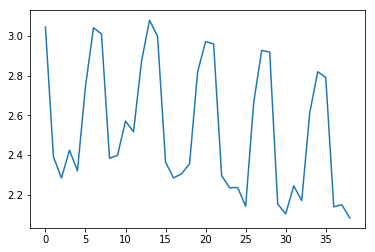

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.419810   
air_0164b9927d20bcc3_2017-04-23              1.603132   
air_0241aa3964b7f861_2017-04-23              2.414161   
air_0328696196e46f18_2017-04-23              2.044217   
air_034a3d5b40d5b1b1_2017-04-23              3.331149   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23  10.243718  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.968572  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.180388  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.723110  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  26.970470

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/3000_ridge_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')